In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
import h5py
import significance_funcs as sf
import copy
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab

In [2]:
for subj in [ "EL011", "EL010","EL012", 'EL013', 'EL014', "EL015", "EL016", "EL017", "EL019","EL020", "EL021"]:
    path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
    cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'
    save_h5 = 0 

    h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
    if os.path.isfile(h5_file):
        print('loading h5')
        EEG_resp = h5py.File(h5_file)
        EEG_resp = EEG_resp['EEG_resp']
    else:
        print('loading npy')
        EEG_resp = np.load(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.npy')
        print('saving '+ h5_file+ ' ....... ')
        with h5py.File(h5_file, 'w') as hf:
            hf.create_dataset("EEG_resp", data=EEG_resp)  

loading npy
saving X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL011\BrainMapping\CR\data\EEG_CR.h5 ....... 
loading npy
saving X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL010\BrainMapping\CR\data\EEG_CR.h5 ....... 
loading npy
saving X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL012\BrainMapping\CR\data\EEG_CR.h5 ....... 
loading npy
saving X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL013\BrainMapping\CR\data\EEG_CR.h5 ....... 
loading npy
saving X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL014\BrainMapping\CR\data\EEG_CR.h5 ....... 
loading npy
saving X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL015\BrainMapping\CR\data\EEG_CR.h5 ....... 
loading npy
saving X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL016\BrainMapping\CR\data\EEG_CR.h5 ....... 
loading npy
saving X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL017\BrainMapping\CR\data\EEG_CR.h5 ....... 
loading npy
saving X:\4 

In [439]:
subj = 'EL023'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos

path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_gen, 'Electrodes')
if not os.path.exists(os.path.join(path_infos, subj + "_labels.xlsx")):
    path_infos = os.path.join(path_gen, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
EEG_resp = np.load(path_patient_analysis + '\\' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')

lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
if "type"in lbls:
    lbls = lbls[lbls.type=='SEEG']
    lbls = lbls.reset_index(drop=True)
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

file_con_all = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
######### Load data
data_all = 1
rerun = 0
if os.path.isfile(file_con):
    # con_trial
    con_trial = pd.read_csv(file_con)
else:
    file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_01_CR01.csv'
    con_trial = pd.read_csv(file_con)
    data_all = 0

In [470]:
file_con

'X:\\4 e-Lab\\\\EvM\\Projects\\EL_experiment\\Analysis\\Patients\\EL023\\BrainMapping/CR/data/con_trial_all.csv'

In [440]:
con_trial

,Chan,Stim,LL,P2P,Hour,Block,Sleep,Num,Num_block,Date,Artefact,d
0,0.0,26.0,1.718129,78.853981,11.0,1.0,0.0,0.0,0.0,20230425.0,0.0,42.74
1,0.0,23.0,3.267766,231.381189,11.0,1.0,0.0,1.0,1.0,20230425.0,0.0,38.66
2,0.0,70.0,1.980536,153.771428,11.0,1.0,0.0,2.0,2.0,20230425.0,0.0,66.59
3,0.0,30.0,2.777549,276.003643,11.0,1.0,0.0,3.0,3.0,20230425.0,0.0,44.47
4,0.0,11.0,3.707645,400.214299,11.0,1.0,0.0,4.0,4.0,20230425.0,0.0,23.65
...,...,...,...,...,...,...,...,...,...,...,...,...
14278,86.0,48.0,2.316345,114.391041,11.0,1.0,0.0,202.0,202.0,20230425.0,0.0,59.58
14279,86.0,20.0,3.357904,182.298799,11.0,1.0,0.0,203.0,203.0,20230425.0,0.0,70.05
14280,86.0,1.0,2.119858,118.130044,11.0,1.0,0.0,204.0,204.0,20230425.0,0.0,90.24
14281,86.0,84.0,5.360536,690.349437,11.0,1.0,0.0,205.0,205.0,20230425.0,0.0,7.00


In [441]:
h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    EEG_resp = h5py.File(h5_file)
    EEG_resp = EEG_resp['EEG_resp']

loading h5


In [122]:
Fs             = 500
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3

#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))
color_elab      = np.zeros((3,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])

In [132]:
freqs_label = ['theta', 'alpha', 'beta']
freqs_band = np.zeros((3,2))
freqs_band[0] = [3,8]
freqs_band[1] = [7,13]
freqs_band[2] = [12,30]

In [ ]:
sc = 19
rc = 65
data = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
stimnum = data.Num.values.astype('int')
resp = np.mean(EEG_resp[rc,stimnum,:],0)
resp = ff.bp_filter(resp, 1, 45, Fs)
resp_LL = LLf.get_LL_all(np.expand_dims(resp,[0,1]), Fs, 0.25)[0][0]
peaks, properties = scipy.signal.find_peaks(resp,height=45, prominence=1)

In [140]:
def get_mt(data, win=5, Fs=500, bw=2, f_range=[0.5, 30], ov=0.9):

    # overlap: 0.5 : 50% , 1: 100% (not moving forward! ) , 0: no overlap for next window
    ov = 1-ov
    window = np.int64(win * Fs)
    s = 0
    fin = window

    # numTaper    = 7
    cont = 0
    # psds, freqs         = mne.time_frequency.psd_array_multitaper(data[0,s:fin], Fs, fmin=0.5, fmax=30,adaptive=True, verbose=0)
    psds, freqs0 = mne.time_frequency.psd_array_multitaper(data[0, s:fin], Fs, fmin=f_range[0], fmax=f_range[1],
                                                           bandwidth=bw,
                                                           verbose=0)
    spec = np.zeros((data.shape[0], len(freqs0), np.round((data.shape[1] - window) / window / ov).astype('int')))

    while cont < spec.shape[2]:
        # psds, freqs         = mne.time_frequency.psd_array_multitaper(data[0,s:fin], Fs, fmin=0.5, fmax=30,adaptive=True, verbose=0)
        psds, freqs = mne.time_frequency.psd_array_multitaper(data[:, s:fin], Fs, fmin=f_range[0], fmax=f_range[1],
                                                              adaptive=False,
                                                              bandwidth=bw, verbose=0)
        if (freqs == freqs0).all():
            spec[:, :, cont] = psds
        else:
            spec[:, :, cont] = np.nan
        s = s + np.round(window * ov).astype('int')
        fin = fin + np.round(window * ov).astype('int')
        cont = cont + 1
        # [pxx]               = pmtm(data[s:fin],numTaper,freq,Fs);

    return spec, freqs

In [133]:
win = 4 * Fs
freqs, psd = signal.welch(EEG_resp[rc, stimnum, 0:Fs], Fs)

In [137]:
len(stimnum)

207

In [ ]:
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
a0.plot(x, y)
a1.plot(y, x)

f.tight_layout()

In [288]:
con_trial

,Chan,Stim,LL,P2P,LL_onset,LL_pre,LL_WOI,Sig,Hour,SleepState,Block,Sleep,Num,Num_block,Date,Artefact,d
0,0.0,38.0,3.112841,265.986196,2.343089,1.877114,2.312714,1,15.0,Wake,1.0,0.0,0.0,0.0,20220215.0,0.0,35.68
1,0.0,40.0,2.724212,240.247410,0.000000,1.947729,-1.000000,0,15.0,Wake,1.0,0.0,1.0,1.0,20220215.0,-1.0,35.35
2,0.0,19.0,2.371869,242.534783,2.343071,1.199924,2.343071,1,15.0,Wake,1.0,0.0,2.0,2.0,20220215.0,0.0,14.23
3,0.0,68.0,1.501889,145.296012,0.000000,1.456643,1.294352,0,15.0,Wake,1.0,0.0,3.0,3.0,20220215.0,0.0,75.99
4,0.0,27.0,1.853082,162.626234,0.000000,2.362543,-1.000000,0,15.0,Wake,1.0,0.0,4.0,4.0,20220215.0,0.0,23.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558571,86.0,85.0,119.101393,13679.636849,0.000000,-1.000000,-1.000000,-1,13.0,Wake,69.0,0.0,10339.0,145.0,20220218.0,2.0,3.50
558572,86.0,47.0,5.375446,283.214409,0.000000,4.760937,-1.000000,0,13.0,Wake,69.0,0.0,10340.0,146.0,20220218.0,-1.0,65.21
558573,86.0,49.0,3.795502,221.487138,2.978491,3.186474,-1.000000,0,13.0,Wake,69.0,0.0,10341.0,147.0,20220218.0,0.0,67.77
558574,86.0,27.0,2.703691,98.190826,0.000000,-1.000000,-1.000000,0,13.0,Wake,69.0,0.0,10342.0,148.0,20220218.0,1.0,66.56


In [292]:
0.75*Fs

375.0

In [295]:
pd.DataFrame(power_rc, columns=['theta', 'alpha', 'beta', 'sig', 'LL'])

,theta,alpha,beta,sig,LL
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
202,0.0,0.0,0.0,1.0,0.0
203,0.0,0.0,0.0,1.0,0.0
204,0.0,0.0,0.0,0.0,0.0
205,0.0,0.0,0.0,1.0,0.0


In [ ]:
mn = np.median(psd[power_rc[:,3]==1,:],0)
st = np.std(psd[power_rc[:,3]==1,:],0)
axs[1].plot(freqs,mn, label = 'sig')
# plt.fill_between(freqs,mn-st,mn+st,alpha=.1)
plt.title('Median Power before Stim')
mn = np.median(psd[power_rc[:,3]==0,:],0)
st = np.std(psd[power_rc[:,3]==0,:],0)
axs[1].plot(freqs, mn, label = 'non-sig')
# plt.fill_between(freqs,mn-st,mn+st,alpha=.1)
axs[1].set_ylabel( 'Power [dB]', fontsize=18)
axs[1].set_xlabel( 'freq [Hz]', fontsize=18)
axs[1].set_xlim([4,30])


In [381]:
np.unique(con_trial.Stim)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 13., 14., 15., 16.,
       18., 19., 20., 24., 25., 26., 27., 28., 29., 36., 37., 38., 39.,
       40., 44., 45., 46., 47., 48., 49., 50., 53., 54., 55., 57., 58.,
       64., 65., 67., 68., 69., 73., 74., 75., 76., 85., 86.])

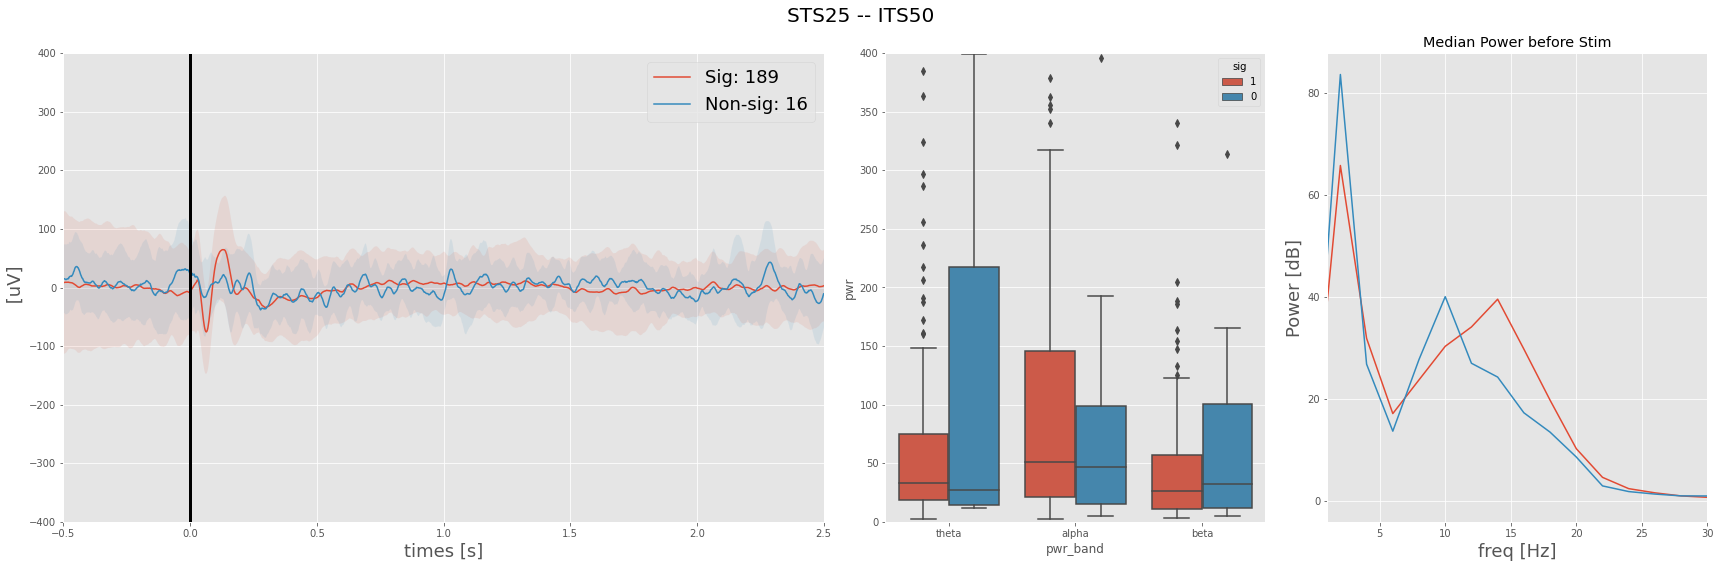

In [438]:
sc = 24
rc = 49
nums = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1)&(con_trial.Sig==1), 'Num'].values.astype('int')
#plt.figure(figsize=(10,6))
fig, axs = plt.subplots(1, 3, figsize=(24,8), gridspec_kw={'width_ratios': [2, 1,1]})
plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc], fontsize=20)
ylim = 400
mn = np.nanmean(EEG_resp[rc, nums, :],0)
st = np.nanstd(EEG_resp[rc, nums, :],0)
ylim = np.nanmax([ylim, np.max(mn+st), np.max(abs(mn-st))])
axs[0].plot(x_ax,mn, label='Sig: '+str(len(nums)))
axs[0].fill_between(x_ax,mn-st,mn+st,alpha=.1)
nums = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1)&(con_trial.Sig==0), 'Num'].values.astype('int')
mn = np.nanmean(EEG_resp[rc, nums, :],0)
st = np.nanstd(EEG_resp[rc, nums, :],0)
ylim = np.nanmin([np.nanmax([ylim, np.max(mn+st), np.max(abs(mn-st))]),800])
ylim = np.ceil(ylim/50)*50
axs[0].plot(x_ax,mn, label='Non-sig: '+str(len(nums)))
axs[0].fill_between(x_ax,mn-st,mn+st,alpha=.1)
axs[0].legend(fontsize=18)

axs[0].axvline(0, color=[0,0,0], linewidth =3)
axs[0].set_xlim([-0.5, 2.5])
axs[0].set_ylim([-ylim,ylim])
axs[0].set_xlabel('times [s]', fontsize=18)
axs[0].set_ylabel(' [uV]', fontsize=18)

nums = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'Num'].values.astype('int')

power_all = np.zeros((1,6))
for i, to_pwer in zip(range(len(freqs_band)), [0, 250, 375]):
    power_rc = np.zeros((len(nums),6))+i
    freqs, psd = signal.welch(EEG_resp[rc, nums, to_pwer:Fs], Fs, nperseg= (500-to_pwer)/2, noverlap= 0.9*((500-to_pwer)/2))
    freq_ix = freqs[(freqs>freqs_band[i,0])&(freqs<freqs_band[i,1])]
    power_rc[:,2] = np.nanmax(psd[:,(freqs>freqs_band[i,0])&(freqs<freqs_band[i,1])],1)
    power_rc[:,3] = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'Sig'].values.astype('int')
    power_rc[:,4] = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'LL'].values
    power_all = np.concatenate([power_all, power_rc],0)
    power_rc[:,5] = nums #
pwr_tab = pd.DataFrame(power_all[1:,1:], columns=['pwr_band','pwr', 'sig', 'LL', 'id'])

sns.boxplot(data=pwr_tab, x="pwr_band", y="pwr", hue="sig", ax=axs[1],hue_order=[1,0] )
axs[1].set_ylim([0,400])
axs[1].set_xticks(np.arange(3), ['theta', 'alpha', 'beta'])


freqs, psd = signal.welch(EEG_resp[rc, nums, 0:Fs], Fs, nperseg= 250, noverlap= 0.9*(250))
power_rc = np.zeros((len(nums),5))
for i in range(len(freqs_band)):
    freq_ix = freqs[(freqs>freqs_band[i,0])&(freqs<freqs_band[i,1])]
    power_rc[:,i] = np.nanmax(psd[:,(freqs>freqs_band[i,0])&(freqs<freqs_band[i,1])],1)
power_rc[:,3] = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'Sig'].values.astype('int')
power_rc[:,4] = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'LL'].values


mn = np.median(psd[power_rc[:,3]==1,:],0)
st = np.std(psd[power_rc[:,3]==1,:],0)
axs[2].plot(freqs,mn, label = 'sig')
# plt.fill_between(freqs,mn-st,mn+st,alpha=.1)
plt.title('Median Power before Stim')
mn = np.median(psd[power_rc[:,3]==0,:],0)
st = np.std(psd[power_rc[:,3]==0,:],0)
axs[2].plot(freqs, mn, label = 'non-sig')
# plt.fill_between(freqs,mn-st,mn+st,alpha=.1)
axs[2].set_ylabel( 'Power [dB]', fontsize=18)
axs[2].set_xlabel( 'freq [Hz]', fontsize=18)
axs[2].set_xlim([1,30])


fig.tight_layout()

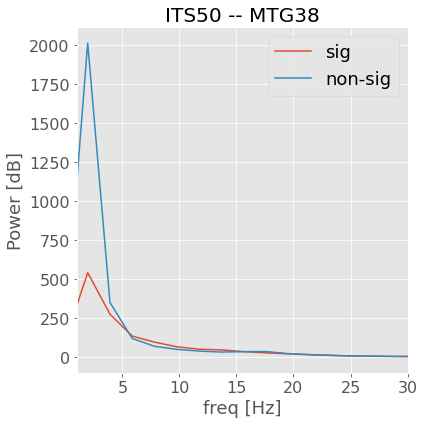

In [251]:
nums = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'Num'].values.astype('int')
freqs, psd = signal.welch(EEG_resp[rc, nums, 0:Fs], Fs)
power_rc = np.zeros((len(nums),5))
for i in range(len(freqs_band)):
    freq_ix = freqs[(freqs>freqs_band[i,0])&(freqs<freqs_band[i,1])]
    power_rc[:,i] = np.nanmax(psd[:,(freqs>freqs_band[i,0])&(freqs<freqs_band[i,1])],1)
power_rc[:,3] = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'Sig'].values.astype('int')
power_rc[:,4] = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'LL'].values

plt.figure(figsize=(6,6))
plt.title(labels_all[sc]+ ' -- '+labels_all[rc], fontsize=20)
mn = np.mean(psd[power_rc[:,3]==1,:],0)
st = np.std(psd[power_rc[:,3]==1,:],0)
plt.plot(freqs,mn, label = 'sig')
# plt.fill_between(freqs,mn-st,mn+st,alpha=.1)

mn = np.mean(psd[power_rc[:,3]==0,:],0)
st = np.std(psd[power_rc[:,3]==0,:],0)
plt.plot(freqs, mn, label = 'non-sig')
# plt.fill_between(freqs,mn-st,mn+st,alpha=.1)
plt.ylabel( 'Power [dB]', fontsize=18)
plt.xlabel( 'freq [Hz]', fontsize=18)
plt.xlim([1,30])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)
plt.tight_layout()

In [191]:
nums = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'Num'].values.astype('int')
freqs, psd = signal.welch(EEG_resp[rc, nums, 0:Fs], Fs)
power_rc = np.zeros((len(nums),5))
for i in range(len(freqs_band)):
    freq_ix = freqs[(freqs>freqs_band[i,0])&(freqs<freqs_band[i,1])]
    power_rc[:,i] = np.nanmax(psd[:,(freqs>freqs_band[i,0])&(freqs<freqs_band[i,1])],1)
power_rc[:,3] = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'Sig'].values.astype('int')
power_rc[:,4] = con_trial.loc[(con_trial.Chan==rc)&(con_trial.Stim==sc)&(con_trial.Artefact<1), 'LL'].values

Text(0.5, 0, 'beta')

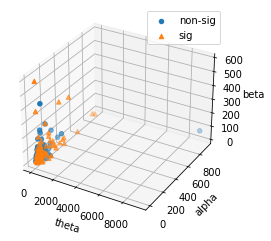

In [192]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lab_sig = ['non-sig', 'sig']
for m, i, zhigh in [('o', 0, -25), ('^', 1, -5)]:
    xs = power_rc[power_rc[:,3]==i,0]
    ys = power_rc[power_rc[:,3]==i,1]
    zs = power_rc[power_rc[:,3]==i,2]
    ax.scatter(xs, ys, zs, marker=m, label = lab_sig[i])
plt.legend()
ax.set_xlabel('theta')
ax.set_ylabel('alpha')
ax.set_zlabel('beta')

(5.0, 500.0)

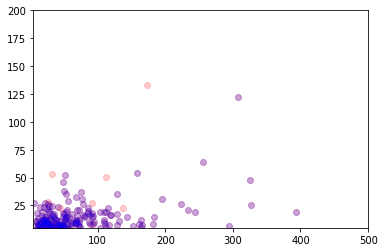

In [184]:
f_inx = 1
plt.plot(power_rc[:,f_inx],power_rc[:,f_inx+1], 'ro', alpha= 0.2)
plt.plot(power_rc[:,f_inx],power_rc[:,f_inx+1]*power_rc[:,3], 'bo', alpha= 0.2)
plt.ylim([5, 200])
plt.xlim([5, 500])
# plt.xlim([0.5,200])

(5.0, 500.0)

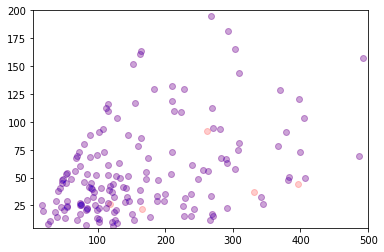

In [183]:
f_inx = 0
plt.plot(power_rc[:,f_inx],power_rc[:,f_inx+1], 'ro', alpha= 0.2)
plt.plot(power_rc[:,f_inx],power_rc[:,f_inx+1]*power_rc[:,3], 'bo', alpha= 0.2)
plt.ylim([5, 200])
plt.xlim([5, 500])
# plt.xlim([0.5,200])

In [ ]:
t = 32
plt.figure(figsize=(8,4))
plt.plot(EEG_resp[rc, nums[t]])
plt.show()
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd[t], color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd[t].max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, 30])
sns.despine()

In [ ]:
freqs, psd = signal.welch(EEG_resp[rc, :, 0:Fs], Fs, nperseg=win)


In [ ]:
data = EEG_resp[rc, nums[0],:]
freqs, psd = signal.welch(data[Fs-win_total:Fs], Fs, nperseg=win)
plt.plot(x_ax, data)
plt.show()
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, 30])
sns.despine()

In [ ]:
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, 30])
sns.despine()

In [ ]:
sc = 10
rc = 1


## Preliminary BM

##### single connection example

In [7]:

k = k+1
rc = chans[k]

# sc_sel = 10
# sc = StimChanIx[sc_sel]
# sc_sm  = StimChanSM[sc_sel]
# stimnum = stimlist.loc[stimlist.ChanP==sc_sm, 'Num']
stimnum= con_trial.loc[(con_trial.Sleep==0)&(con_trial.Stim==sc)&(con_trial.Chan==rc),'Num'].values.astype('int')
d = np.round(scipy.spatial.distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.figure(figsize=(10,8))
plt.title(labels_clinic[sc]+'('+ labels_all[sc]+')  --- '+ labels_clinic[rc]+'('+ labels_all[rc]+'), d: '+str(d)+'mm', fontsize=20)
mn= np.mean(EEG_resp[rc,stimnum,:],0)
st = np.std(EEG_resp[rc,stimnum,:],0)
plt.plot(x_ax, mn, color=[0,0,0])
plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2, color=[0,0,0])
plt.axvspan(0,0.01, color=[1,0,0])
plt.xlim([-0.25,2])
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('uV', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-800,800])
plt.text(1, -600, 'n: '+str(len(stimnum)), fontsize=15)
#plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\EL018\BrainMapping\example\\'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
# plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\EL018\BrainMapping\example\\'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
plt.show()


NameError: name 'chans' is not defined

In [70]:
def plot_BM_CR_trial_sig(M, labels,areas, label, t):
    cmap_LL = 'hot'
    M[np.isnan(M)] = -1
    
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(25,25))
    
    cmap = copy.copy(plt.cm.get_cmap(cmap_LL))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
    cmap.set_under('black')
    cmap.set_bad('black')
    M = np.ma.masked_equal(M, 0)
            
            
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, vmin=0, vmax=8) # np.percentile(M, 95)
    plt.xlim([-1.5, M.shape[0]-0.5])
    plt.ylim([-0.5, M.shape[1]+0.5])
    plt.xticks(range(M.shape[1]), labels[:M.shape[1]], rotation=90);
    plt.yticks(range(M.shape[0]), labels[:M.shape[0]]);
    for i in range(len(labels)):
        r         = areas[i]
        if i <=M.shape[1]:
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        if i <=M.shape[0]:
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    #axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    #circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    #plt.text(0.3,0.3, time)
    #plt.axis('off')
    #axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- Sig')
    plt.savefig(path_patient_analysis + '/BrainMapping/CR/figures/BM_plot/BM_'+label+'.png', dpi = 300)
    Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/').mkdir(parents=True, exist_ok=True)
    # plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/'+'BM_clin.png', )
    plt.show()
    #plt.close(fig) #plt.show()#
    


In [130]:
sc = 19
rc = 65
data = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
stimnum = data.Num.values.astype('int')
resp = np.mean(EEG_resp[rc,stimnum,:],0)
resp = ff.bp_filter(resp, 1, 45, Fs)
resp_LL = LLf.get_LL_all(np.expand_dims(resp,[0,1]), Fs, 0.25)[0][0]
peaks, properties = scipy.signal.find_peaks(resp,height=45, prominence=1)

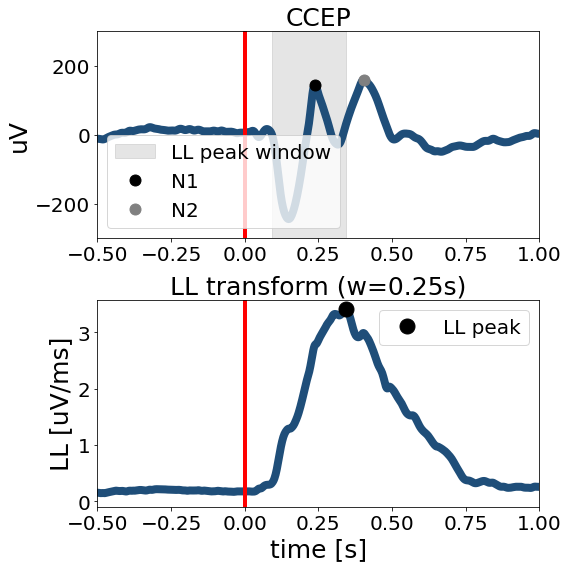

In [131]:
fig, axes = plt.subplots(2, figsize=(8,8))
fig.patch.set_facecolor('xkcd:white')
axes[0].plot(x_ax, resp, color= color_elab[0], linewidth=8)
axes[0].set_ylim([-300,300])
axes[0].set_xlabel('', fontsize=25)
axes[0].set_ylabel('uV', fontsize=25)
axes[0].set_title('CCEP', fontsize=25)
axes[0].axvspan((np.argmax(resp_LL)-Fs)/Fs-0.125, (np.argmax(resp_LL)-Fs)/Fs+0.125, color=[0,0,0], alpha=0.1, label = 'LL peak window')
axes[0].plot(peaks[0]/Fs-1, resp[peaks[0]], "ko",  label ='N1', markersize=11)
axes[0].plot(peaks[1]/Fs-1, resp[peaks[1]], "o",color = 'grey', label ='N2', markersize=11)
axes[0].legend(fontsize=20)
axes[1].plot(x_ax+0.125, resp_LL, color= color_elab[0], linewidth=8)
axes[1].plot((np.argmax(resp_LL)-Fs)/Fs+0.125, np.max(resp_LL), 'ko', markersize=15, label = 'LL peak')
axes[1].legend(fontsize=20)
axes[1].set_xlabel('time [s]', fontsize=25)
axes[1].set_ylabel('LL [uV/ms]', fontsize=25)
axes[1].set_title('LL transform (w=0.25s)', fontsize=25)

for i in range(2):
    axes[i].set_xlim([-0.5, 1])
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    axes[i].axvline(0, color=[1,0,0], linewidth=4)
plt.tight_layout()

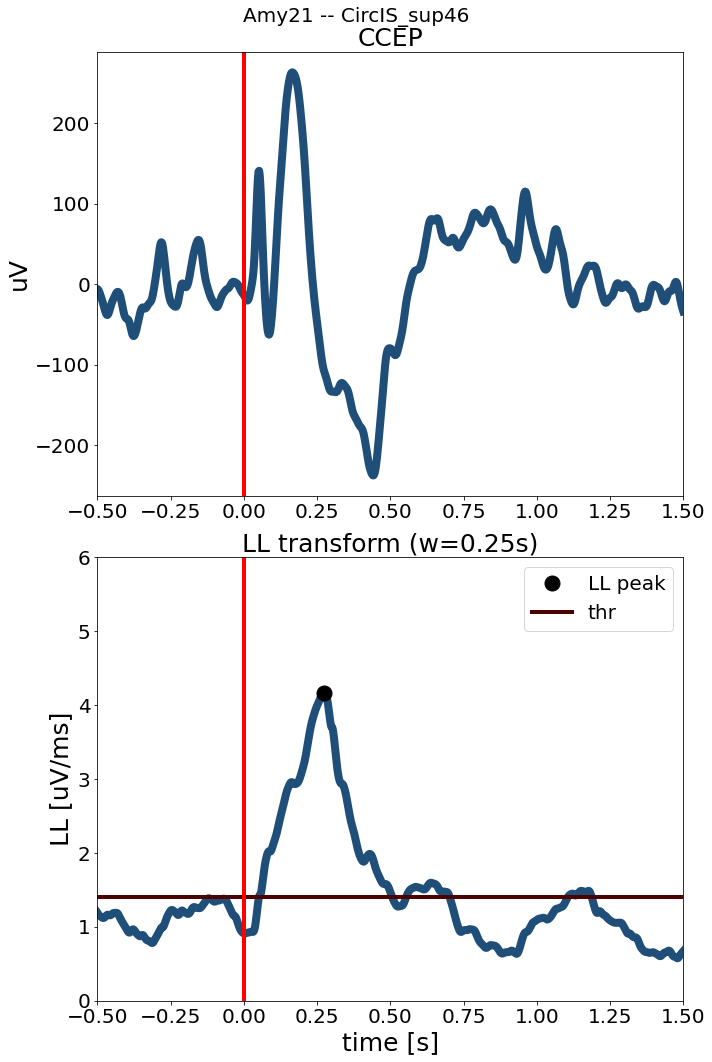

In [119]:
sc = 20
rc = 45
data = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
stimnum = data.Num.values.astype('int')
resp = np.mean(EEG_resp[rc,stimnum,:],0)
resp = ff.lp_filter(resp, 45, Fs)
resp_LL = LLf.get_LL_all(np.expand_dims(resp,[0,1]), Fs, 0.25)[0][0]
thr = np.percentile(np.concatenate([resp_LL[int((w / 2) * Fs):int((t_0 - w / 2) * Fs)],
                                            resp_LL[int(3 * Fs):int((4 - w / 2) * Fs)]]),99)

fig, axes = plt.subplots(2, figsize=(10,15))
plt.suptitle(labels_all[sc]+' -- '+labels_all[rc], fontsize=20)
fig.patch.set_facecolor('xkcd:white')
axes[0].plot(x_ax, resp, color= color_elab[0], linewidth=8)
#axes[0].set_ylim([-300,300])
axes[0].set_xlabel('', fontsize=25)
axes[0].set_ylabel('uV', fontsize=25)
axes[0].set_title('CCEP', fontsize=25)
# axes[0].axvspan((np.argmax(resp_LL)-Fs)/Fs-0.125, (np.argmax(resp_LL)-Fs)/Fs+0.125, color=[0,0,0], alpha=0.1, label = 'LL peak window')
# axes[0].legend(fontsize=20)
axes[1].plot(x_ax+0.125, resp_LL, color= color_elab[0], linewidth=8)
resp_LL[:500] = 0
resp_LL[800:] = 0
axes[1].plot((np.argmax(resp_LL)-Fs)/Fs+0.125, np.max(resp_LL), 'ko', markersize=15, label = 'LL peak')

axes[1].set_xlabel('time [s]', fontsize=25)
axes[1].set_ylabel('LL [uV/ms]', fontsize=25)
axes[1].set_title('LL transform (w=0.25s)', fontsize=25)
axes[1].axhline(thr, color=[0.3,0,0], linewidth=4, label = 'thr')
lim = np.max([4, np.ceil(1.25*np.max(resp_LL))])
axes[1].set_ylim([0,lim])
axes[1].legend(fontsize=20)

for i in range(2):
    axes[i].set_xlim([-0.5, 1.5])
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    axes[i].axvline(0, color=[1,0,0], linewidth=4)
plt.tight_layout()
plt.savefig(path_patient_analysis + '/BrainMapping/CR/figures/BM_plot//'+labels_all[sc]+'_'+labels_all[rc]+'.png', dpi = 300)

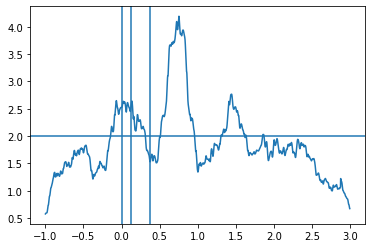

In [59]:
plt.plot(x_ax, resp_LL)
plt.axhline(thr)
plt.axvline(0)
plt.axvline(0.125)
plt.axvline(0.375)

In [60]:
LL_t = np.array(resp_LL[int((t_0 + w/2) * Fs):int((t_0 + 0.5-w/2) * Fs)] > thr) * 1
sf.search_sequence_numpy(LL_t, np.ones((int((w) * Fs),)))

[]

In [443]:
np.unique(con_trial.Stim).astype('int')

array([ 0,  1,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37,
       38, 39, 40, 41, 44, 45, 46, 47, 48, 50, 51, 52, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 69, 70, 73, 74, 75, 76, 77, 78, 79, 82, 83, 84, 85,
       86])

In [445]:
con_trial

,Chan,Stim,LL,P2P,Hour,Block,Sleep,Num,Num_block,Date,Artefact,d
0,0.0,26.0,1.718129,78.853981,11.0,1.0,0.0,0.0,0.0,20230425.0,0.0,42.74
1,0.0,23.0,3.267766,231.381189,11.0,1.0,0.0,1.0,1.0,20230425.0,0.0,38.66
2,0.0,70.0,1.980536,153.771428,11.0,1.0,0.0,2.0,2.0,20230425.0,0.0,66.59
3,0.0,30.0,2.777549,276.003643,11.0,1.0,0.0,3.0,3.0,20230425.0,0.0,44.47
4,0.0,11.0,3.707645,400.214299,11.0,1.0,0.0,4.0,4.0,20230425.0,0.0,23.65
...,...,...,...,...,...,...,...,...,...,...,...,...
14278,86.0,48.0,2.316345,114.391041,11.0,1.0,0.0,202.0,202.0,20230425.0,0.0,59.58
14279,86.0,20.0,3.357904,182.298799,11.0,1.0,0.0,203.0,203.0,20230425.0,0.0,70.05
14280,86.0,1.0,2.119858,118.130044,11.0,1.0,0.0,204.0,204.0,20230425.0,0.0,90.24
14281,86.0,84.0,5.360536,690.349437,11.0,1.0,0.0,205.0,205.0,20230425.0,0.0,7.00


In [452]:
con_trial[(con_trial.Stim==0)&(con_trial.Chan==3)&(con_trial.Artefact<1)]

,Chan,Stim,LL,P2P,Hour,Block,Sleep,Num,Num_block,Date,Artefact,d
444,3.0,0.0,4.633090,380.147923,11.0,1.0,0.0,30.0,30.0,20230425.0,0.0,10.5
534,3.0,0.0,4.195230,427.908727,11.0,1.0,0.0,120.0,120.0,20230425.0,0.0,10.5
557,3.0,0.0,5.093481,376.476284,11.0,1.0,0.0,143.0,143.0,20230425.0,0.0,10.5


In [22]:
t_0 = 1
w = 0.25 
stimchans = np.unique(con_trial.Stim).astype('int')
M = np.zeros((len(labels_all),len(labels_all)))
for sc in stimchans:
    for rc in range(len(labels_all)):
        data = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
        stimnum = data.Num.values.astype('int')
        if len(stimnum)>0:
            resp = np.mean(EEG_resp[rc,stimnum,:],0)
            resp = ff.lp_filter(resp, 45, Fs)
            resp_LL = LLf.get_LL_all(np.expand_dims(resp,[0,1]), Fs, w)[0][0]
            
            thr = np.percentile(np.concatenate([resp_LL[int((w / 2) * Fs):int((t_0 - w / 2) * Fs)],
                                            resp_LL[int(3 * Fs):int((4 - w / 2) * Fs)]]),
                            99)  # LL_resp[0, 0, int((t_0+0.5) * Fs):] = 0 * Fs):] = 0
            LL_t = np.array(resp_LL[int((t_0 + w/2) * Fs):int((t_0 + 0.5-w/2) * Fs)] > thr) * 1
            t_resp_all = sf.search_sequence_numpy(LL_t, np.ones((int((w + 0.01) * Fs),)))

            if len(t_resp_all) > 0:
                M[sc,rc] = np.nanmax(resp_LL[562:687])
        else:
            M[sc,rc] = np.nan

In [465]:
labels_clin = np.delete(labels_clinic, bad_all2, 0)
areas_sel = np.delete(labels_region, bad_all2, 0)
labels_sel = np.delete(labels_all, bad_all2, 0)
labels_sel = labels_sel +' (' +labels_clin+')'

In [466]:
M_resp       = np.delete(np.delete(M, bad_all2, 0), bad_all2, 1)

In [450]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
WM_chans = np.where(labels_region == 'WM')[0]
#WM_chans = np.where(labels_region == 'Unknown')[0]
bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans])).astype('int')
bad_all2 = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')

In [467]:
ind = np.argsort(areas_sel)
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]
M_resp = M_resp[ind,:]
M_resp = M_resp[:,ind]

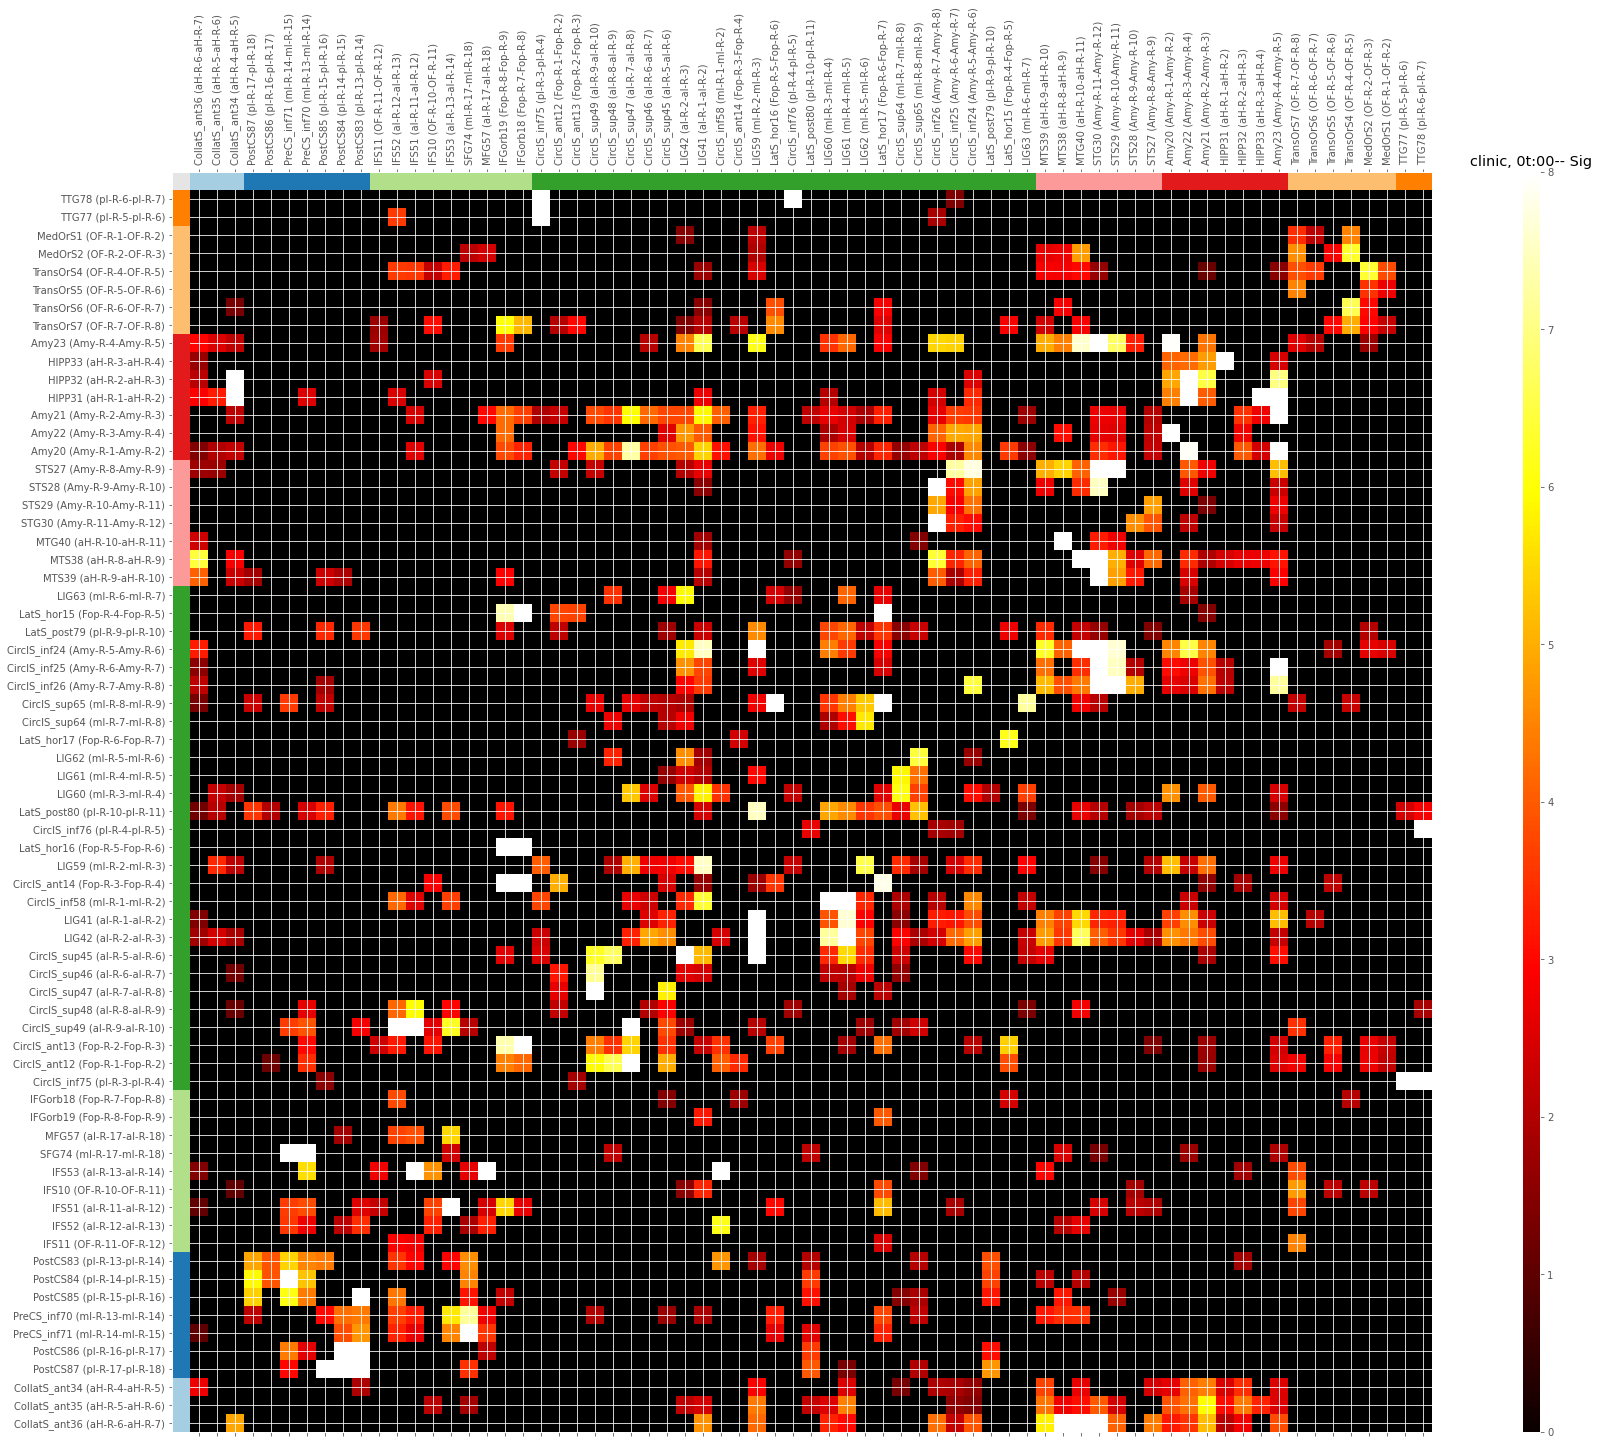

In [469]:
ll = 'clinic'
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')

In [24]:
regions       = np.unique(labels_region)
color_regions = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6',"#8FB996"]

#v= np.sort(labels_region)
#region_border = np.where(np.roll(v,1)!=v)[0]
#region_border = np.concatenate([region_border, [len(labels_all)]])
#region_num = np.diff(region_border)
#labels_sort     = labels_all[np.argsort(labels_region)]
#labels_region_sort = np.sort(labels_region)
#StimChanIx_sort = np.argsort(labels_region)

In [32]:
bad_all2

array([ 2,  7,  8, 36, 42, 43, 49, 53, 54, 55, 65, 66, 67, 68, 71, 72, 80,
       81])

In [31]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
WM_chans = np.where(labels_region == 'WM')[0]
#WM_chans = np.where(labels_region == 'Unknown')[0]
bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans])).astype('int')
bad_all2 = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')

## Plot examples (sleep, Sig,..)

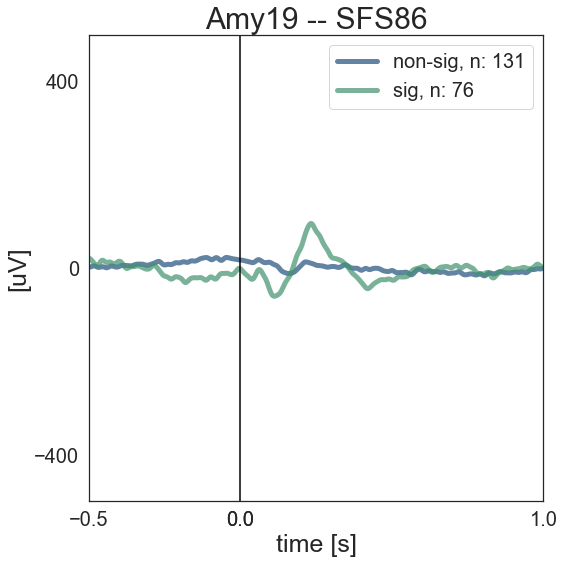

In [106]:
###plot mean of sig and non-sig trials

def plot_wake_trials():
    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style='white')
    plt.title(labels_all[sc] + ' -- ' + labels_all[rc], fontsize=30)
    ylim = 300

        #fig.add_subplot(gs[0, sig])
    #gs = fig.add_gridspec(1,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for sig, sig_lab in zip([0,1,2],['Wake', 'NREM', 'REM']):
        stimnum = lists.loc[(lists.SleepState==sig_lab),'Num'].values.astype('int')
        #fig.add_subplot(gs[0, sig])
        # for i in range(len(stimnum)):
        #    plt.plot(x_ax, EEG_CR[rc, stimnum[i],:], color=color_elab[0], alpha=0.5)
        mn = np.mean(ff.lp_filter(EEG_resp[rc, stimnum,:],30,Fs),0)
        st= np.std(ff.lp_filter(EEG_resp[rc, stimnum,:],30,Fs),0)
        plt.plot(x_ax, mn, color=color_elab[sig], linewidth=5, alpha=0.7, label=sig_lab+', n: '+str(len(stimnum)))
        # st= np.std(ff.lp_filter(trials,30,Fs),0)
        # plt.fill_between(x_ax,mn-st, mn+st,color=color_elab[sig*2], alpha=0.2 )
    plt.xticks([-0.5, 0,0., 1], fontsize=20)
    plt.yticks([-400, 0, 400], fontsize=20)
    plt.xlabel('time [s]', fontsize=25)
    plt.ylabel('[uV]', fontsize=25)
    plt.legend( fontsize=20)
    plt.axvline(0, color=[0,0,0], label='stim')
        # plt.text(-0.3, 500, 'n: '+str(len(stimnum)), fontsize=20)
        #plt.title('Mean Across All Trials', fontsize=25)
    plt.xlim([-0.5, 1])
    plt.ylim([-ylim,ylim])
    plt.tight_layout()
    plt.savefig(path_patient_analysis + '\\' + folder + '\\'+cond_folder+'\\methods\\sleep_trials\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_SS.svg')
    # plt.savefig(path_patient_analysis + '\\' + folder + '\\'+cond_folder+'\\methods\\CC_surr_example\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_'+m+'.jpg')
    plt.axvspan(0,0.25, alpha=0.1)
    plt.show()
    
def plot_sig_trials():
    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style='white')
    plt.title(labels_all[sc] + ' -- ' + labels_all[rc], fontsize=30)
    ylim = 500

        #fig.add_subplot(gs[0, sig])
    #gs = fig.add_gridspec(1,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for sig, sig_lab in zip([0,1],['non-sig', 'sig']):
        stimnum = lists.loc[lists.Sig==sig,'Num'].values.astype('int')
        #fig.add_subplot(gs[0, sig])
        # for i in range(len(stimnum)):
        #    plt.plot(x_ax, EEG_CR[rc, stimnum[i],:], color=color_elab[0], alpha=0.5)
        mn = np.mean(ff.lp_filter(EEG_resp[rc, stimnum,:],45,Fs),0)
        st= np.std(ff.lp_filter(EEG_resp[rc, stimnum,:],45,Fs),0)
        plt.plot(x_ax, mn, color=color_elab[sig*2], linewidth=5, alpha=0.7, label=sig_lab+', n: '+str(len(stimnum)))
        # st= np.std(ff.lp_filter(trials,30,Fs),0)
        # plt.fill_between(x_ax,mn-st, mn+st,color=color_elab[sig*2], alpha=0.2 )
    plt.xticks([-0.5, 0,0., 1], fontsize=20)
    plt.yticks([-400, 0, 400], fontsize=20)
    plt.xlabel('time [s]', fontsize=25)
    plt.ylabel('[uV]', fontsize=25)
    plt.legend( fontsize=20)
    plt.axvline(0, color=[0,0,0], label='stim')
        # plt.text(-0.3, 500, 'n: '+str(len(stimnum)), fontsize=20)
        #plt.title('Mean Across All Trials', fontsize=25)
    plt.xlim([-0.5, 1])
    plt.ylim([-ylim,ylim])
    plt.tight_layout()
    # plt.savefig(path_patient_analysis + '\\' + folder + '\\'+cond_folder+'\\methods\\trial_sig_example\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    # plt.savefig(path_patient_analysis + '\\' + folder + '\\'+cond_folder+'\\methods\\CC_surr_example\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_'+m+'.jpg')

    plt.show()
    
#k = np.random.choice(len(dat_plot),1)[0]
sc = 18
rc= 85
lists = con_trial[(con_trial['Artefact'] <1) & (con_trial['Chan'] == rc) & (con_trial['Stim'] == sc)]
plot_sig_trials()

## with sig level

In [ ]:
file_sig_con = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\sig_con.csv'

sig_con = pd.read_csv(file_sig_con)

In [ ]:
summ = con_trial_sig[(con_trial.Artefact==0)]
summ = summ.groupby(['Stim', 'Chan'], as_index=False)['Sig'].mean()#summ[summ.Sig_block>3]

In [ ]:
M = np.zeros((len(labels_all), len(labels_all))) - 1
# M[:, :] = np.nan
for sc in np.unique(summ.Stim).astype('int'):
    chan = summ.loc[summ.Stim == sc, 'Chan'].values.astype('int')
    LL = summ.loc[summ.Stim == sc, 'Sig'].values
    M[sc, chan] = LL

In [ ]:
con_trial_sig = con_trial[(con_trial.Sleep < 5) & (con_trial.d > -10)]
con_trial_sig = con_trial_sig.reset_index(drop=True)
con_trial_sig.loc[con_trial_sig.Sig < 0, 'Sig'] = np.nan
con_trial_sig.insert(4, 'LL_sig', np.nan)
con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL_sig'] = con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL']
con_trial_sig = con_trial_sig.drop(columns='LL')
con_trial_sig.insert(4, 'LL', con_trial_sig.LL_sig)
con_trial_sig.insert(4, 'Prob', con_trial_sig.Sig)
con_trial_sig = con_trial_sig.drop(columns='LL_sig')
con_trial_sig = con_trial_sig[(con_trial_sig.Block >=1)]
con_trial_sig = con_trial_sig.reset_index(drop=True)
# labels:
labels_sel = np.delete(labels_clinic, bad_chans, 0)
areas_sel = np.delete(labels_region, bad_chans, 0)
# # sort
# ind = np.argsort(areas_sel)
# areas_sel = np.delete(self.labels_region, self.bad_all, 0)
# labels_sel = labels_sel[ind]
# areas_sel = areas_sel[ind]

In [ ]:
import copy

In [ ]:
def plot_BM_CR_trial_sig(M, labels,areas, label, t):
    cmap_LL = 'hot'
    M[np.isnan(M)] = -1
    
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(25,25))
    
    cmap = copy.copy(plt.cm.get_cmap(cmap_LL))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
    cmap.set_under('black')
    cmap.set_bad('black')
    M = np.ma.masked_equal(M, 0)
            
            
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, vmin=0, vmax=1) # np.percentile(M, 95)
    plt.xlim([-1.5, M.shape[0]-0.5])
    plt.ylim([-0.5, M.shape[1]+0.5])
    plt.xticks(range(M.shape[1]), labels[:M.shape[1]], rotation=90);
    plt.yticks(range(M.shape[0]), labels[:M.shape[0]]);
    for i in range(len(labels)):
        r         = areas[i]
        if i <=M.shape[1]:
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        if i <=M.shape[0]:
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    #axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    #circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    #plt.text(0.3,0.3, time)
    #plt.axis('off')
    #axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- Sig')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    #Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/').mkdir(parents=True, exist_ok=True)
    plt.savefig('X:\\4 e-Lab\EvM\Projects\EL_experiment\Analysis\Patients\EL020\BrainMapping\CR\BM_figures\General\\'+'BM_clin.jpg')

    #plt.close(fig) #plt.show()#
    


In [ ]:
labels_sel   = np.delete(labels_h.values, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all2, 1)

# sort
ind = np.argsort(areas_sel)
M_resp= M_resp[ind,:]
M_resp = M_resp[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]
ll = 'test_clinic'
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')

In [ ]:
M[sc,rc]

In [ ]:
sc = 2
rc = 48

In [ ]:
sc = 40
rc = 54
ylim = 800
# sc_sel = 10
# sc = StimChanIx[sc_sel]
# sc_sm  = StimChanSM[sc_sel]
# stimnum = stimlist.loc[stimlist.ChanP==sc_sm, 'Num']
stimnum= con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc),'Num'].values.astype('int')
d = np.round(scipy.spatial.distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.figure(figsize=(10,8))
plt.title(labels_clinic[sc]+'('+ labels_all[sc]+')  --- '+ labels_clinic[rc]+'('+ labels_all[rc]+'), d: '+str(d)+'mm', fontsize=20)
mn= np.nanmean(EEG_resp[rc,stimnum,:],0)
#st = np.std(EEG_resp[rc,stimnum,:],0)
for i in range(len(stimnum)):
    plt.plot(x_ax, EEG_resp[rc,stimnum[i],:])
plt.plot(x_ax, mn, color=[0,0,0], linewidth=4)
#plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2)
plt.axvspan(0,0.01, color=[1,0,0])
plt.xlim([-0.5,1])
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('uV', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-ylim,ylim])
plt.show()

stimnum= con_trial.loc[(con_trial.Stim==rc)&(con_trial.Chan==sc),'Num'].values.astype('int')
d = np.round(scipy.spatial.distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.figure(figsize=(10,8))
plt.title(labels_clinic[rc]+'('+ labels_all[rc]+')  --- '+ labels_clinic[sc]+'('+ labels_all[sc]+'), d: '+str(d)+'mm', fontsize=20)
mn= np.nanmean(EEG_resp[sc,stimnum,:],0)
#st = np.std(EEG_resp[rc,stimnum,:],0)
for i in range(len(stimnum)):
    plt.plot(x_ax, EEG_resp[sc,stimnum[i],:])
plt.plot(x_ax, mn, color=[0,0,0], linewidth=4)
#plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2)
plt.axvspan(0,0.01, color=[1,0,0])
plt.xlim([-0.5,1])
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('uV', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-ylim,ylim])
plt.show()


## First versions

In [ ]:
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')

In [ ]:
M_resp.shape

In [ ]:
def plot_BM_CR_trial_sig(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(25,25))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, origin='lower',cmap='hot', vmin=1, vmax= 9)
    plt.xlim([-1.5, M.shape[0]-0.5])
    plt.ylim([-0.5, M.shape[1]+0.5])
    plt.xticks(range(M.shape[1]), labels[:M.shape[1]], rotation=90);
    plt.yticks(range(M.shape[0]), labels[:M.shape[0]]);
    for i in range(len(labels)):
        r         = areas[i]
        if i <=M.shape[1]:
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        if i <=M.shape[0]:
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    #axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    #circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    #plt.text(0.3,0.3, time)
    #plt.axis('off')
    #axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    #Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/').mkdir(parents=True, exist_ok=True)
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/BM_'+label+'.jpg')
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/BM_'+label+'.jpg')
    #plt.close(fig) #plt.show()#
    


In [ ]:
file_con = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\con_trial_all.csv'
con_trial    = pd.read_csv(file_con)

In [ ]:
sc  =6
rc = 62#rc+1
plot_mean(sc, rc, con_trial[con_trial.Artefact==0],EEG_resp, labels_clinic)
plt.ylim([-500,500])

In [ ]:
#b =1
y = 'LL'
summ = con_trial[(con_trial.Artefact==0)&(con_trial.LL>0)]
summ = summ.groupby(['Stim', 'Chan'], as_index=False)[y].mean()#summ[summ.Sig_block>3]
#t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
M = np.zeros((len(labels_all),len(labels_all)))
for sc in np.unique(summ.Stim).astype('int'):
    chan = summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
    LL   = summ.loc[summ.Stim==sc, y].values
    M[sc,chan] = LL
M = np.nan_to_num(M)
# BM plot
labels_sel   = np.delete(labels_all, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)

# sort
#ind = np.argsort(areas_sel)
#M_resp= M_resp[ind,:]
#M_resp = M_resp[:,ind]
#labels_sel = labels_sel[ind]
#areas_sel = areas_sel[ind]
ll = 'test_clinic'
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')
#i = i+1

In [ ]:
import LL_funcs as LLf

In [ ]:
cond_folder ='CR'

In [ ]:

file = path_analysis+'\\BrainMapping\\' + cond_folder + '\\data\\con_trial_all.csv'
con_trial.to_csv(file, index=False, header=True)

In [ ]:
EEG_resp.shape

In [ ]:
con_trial

In [ ]:
sc  = 10
rc = 3#rc+1
plot_mean(sc, rc, con_trial,EEG_resp, labels_clinic)

In [ ]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
bad_all = np.unique(np.concatenate([bad_region, bad_chans, non_stim])).astype('int')

In [ ]:
block_l = file[-11:-4]
file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_' + block_l + '.csv'
con_trial.to_csv(file, index=False, header=True)

In [ ]:
chan, trial = np.where(np.max(abs(EEG_resp[:, :, int(0.98 * Fs):int(1.008 * Fs)]), 2) > 2000)
for i in range(len(trial)):
    con_trial.loc[
        (con_trial.Chan == chan[i]) & (con_trial.Num_block == trial[i]), 'LL'] = np.nan
con_trial.loc[(con_trial.LL > 40), 'LL'] = np.nan
con_trial = con_trial[~ np.isin(con_trial.Chan, bad_region)]
con_trial = con_trial[~ np.isin(con_trial.Stim, bad_region)]

In [ ]:
def plot_BM_CR_trial_sig(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=2.7, vmax= 6)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    #axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    #circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    #plt.text(0.3,0.3, time)
    #plt.axis('off')
    #axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    #Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/').mkdir(parents=True, exist_ok=True)
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/BM_'+label+'.jpg')
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/BM_'+label+'.jpg')
    #plt.close(fig) #plt.show()#
    


In [ ]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 200

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    resp_all = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    # w_LL =0.1
    # resp_LL = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_all,0),0), 500, w_LL, 1, 0)
    # resp_LL =resp_LL[0,0,:]
    # start_resp = np.argmax(resp_LL[int(t0*Fs):int((t0+0.5)*Fs)])/Fs-w_LL/2+0.01
    #print(start_resp)
    plt.plot(x_ax,resp_all, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    #plt.plot(x_ax,resp_LL*100, c=[1,0,0], linewidth=3, label='LL')
    ## finding peaks
    t_0=1
    resp_z = ff.lp_filter(np.mean(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0),45,Fs)
    # #std_z = np.std(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0)
    # # plt.plot(x_ax,resp_z*100, c=[1,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    # #start_resp = 0
    # #print(np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])))
    # if np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])) > 2.5:
    #     ## get start resp
    #     
    #     # peaks_p, properties_all = scipy.signal.find_peaks(
    #     #     (resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
    #     #     distance=0.01 * Fs, width=1)  #
    #     # peaks_n, properties_all = scipy.signal.find_peaks(
    #     #     -(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
    #     #     distance=0.01 * Fs, width=1)  #
    #     # print(np.concatenate([peaks_p, peaks_n]))
    #     # if (len(peaks_p)+len(peaks_n))>0:
    #     #     #print(np.concatenate([peaks_p, peaks_n]))
    #     #     peaks_all =min(np.concatenate([peaks_p, peaks_n]))
    #     #     #w = scipy.signal.peak_widths(abs(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), [peaks_all],rel_height=0.2)[0]
    #     #     
    #     #     start_resp = (peaks_all) / Fs - 0.02# (peaks_all - w) / Fs - 0.01
    #     if start_resp < 0.01:
    #         start_resp = 0
# 
    #     pk, peak_s, p = get_peaks_all(resp_z,start_resp)
    # 
    #     plt.plot(peak_s, resp_all[pk.astype('int')], "^", color= [1,0,0])
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(start_resp+0.01,start_resp+0.05, alpha=0.8, color=color_elab[1])
    #plt.axvspan(start_resp+0.08, start_resp+0.4, alpha=0.8, color=color_elab[1])
    plt.legend()
    #plt.show()

In [ ]:
c = 3
fig = plt.figure(figsize=(15,5))
plt.plot(x_ax, EEG_resp[c,103,:],linewidth=7, color=color_elab[0])
plt.xticks([-0.5, 0, 0.5])
plt.axvline(-0.01, linewidth=5, color=[1,0,0])
plt.axvspan(0.01, 0.04, alpha=0.1)
plt.axvspan(0.08, 0.25, alpha=0.1)
plt.xlim([-0.5, 1])
plt.axis('off')

fig = plt.figure(figsize=(10,30))
n = 6
e = 9
stimNum = 555
gs       = fig.add_gridspec(7,1)
for i in range(n):
    fig.add_subplot(gs[i,0])
    
    plt.xticks([])
    plt.xlim([-1, 1.5])

    plt.ylim([-600,600])
    plt.plot(x_ax, EEG_resp[i+e,stimNum,:],linewidth=10, color=color_elab[0])
    
    plt.axvline(0, linewidth=5, color=[1,0,0])
    plt.axis('off')

plt.xticks([-1, 0, 1])
fig.tight_layout() 

plt.show()

In [ ]:
## load
if cc==1:
    EEG_resp = np.load(path_patient + '/Analysis/BrainMapping/data/All_resps_all.npy')

else:
    EEG_resp = np.load(path_patient + '/Analysis/BrainMapping/data/All_resps_'+file[-11:-4]+'.npy')
stimlist = pd.read_csv(file)
stimlist.StimNum = np.arange(len(stimlist))
stimlist = stimlist[(stimlist.condition==0)&(stimlist.currentflow==100)]
print('data loaded with '+str(EEG_resp.shape[1])+' stimulations')
print(EEG_resp.shape)

if os.path.isfile(path_patient + '/Analysis/BrainMapping/data/badchan.csv'):
    badchans  = pd.read_csv(path_patient + '/Analysis/BrainMapping/data/badchan.csv')
    bad_chans = np.unique(np.array(np.where(badchans.values[:,1:]==1))[0,:])
else:
    bad_chans = []
if len(stimlist)!= EEG_resp.shape[1]:
    print("WARNING: number of stimulations don't agree!")
    
#badchans.to_csv(path_patient + '/Analysis/BrainMapping/data/badchan.csv', index=False,header=True)

for c in [49, 26,21,18, 9, 10]:
    badchans.loc[badchans.Chan==c, '2'] =1
badchans.to_csv(path_patient + '/Analysis/BrainMapping/data/badchan.csv', index=False,header=True)
badchans = pd.read_csv(path_patient + '/Analysis/BrainMapping/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:,1:]==1))[0,:])

In [ ]:
lbls            = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all, labels_region,labels_clinic,coord_all,StimChans, StimChanSM,StimChansC, StimChanIx, stimlist  = get_Stim_chans(stimlist, lbls)
bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

In [ ]:
labels_clinic

In [ ]:
lbls            = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all, labels_region,labels_clinic,coord_all,StimChans, StimChanSM,StimChansC, StimChanIx, stimlist  = get_Stim_chans(stimlist, lbls)
bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

In [ ]:
def get_LL_thr(EEG_resp, LL_all, labels_all, path_patient, n_trial=3):
    ## get threshoold value for each response channel (99th and 95h)
    chan_thr = np.zeros((len(labels_all), 4))
    for rc in range(len(labels_all)):
        chan_thr[rc,:] = get_sig_thr(rc, LL_all, EEG_resp, n_trial)
    data_A = pd.DataFrame(chan_thr, columns=['99', '95', 'std', 'mean'])
    file   = path_patient + '/Analysis/BrainMapping/LL/chan_sig_thr_single.csv'
    data_A.to_csv(file, index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    print('Data stored: '+file)
    return chan_thr
def LL_mx(EEG_trial, Fs=500, w=0.25,t0=1.01):
    # calculate mean response and get LL (incl peak)
    resp           = ff.lp_filter(np.mean(EEG_trial,0),45,Fs)
    LL_resp        = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp        = LL_resp[0,0]
    mx             = np.max(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    mx_ix          = np.argmax(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    return mx, mx_ix, LL_resp

def get_sig_thr(rc, LL_CCEP, EEG_resp, t_num, Fs=500,fig_path='no'):
    # t_num = number of trials included for mean calculation, IO =3
    BL_times       = np.concatenate([np.arange(0, 0.5, 0.01),np.arange(1.6, 2,0.01)])  # times wihtout stimulation, 0-0.5s, 1.6 - 2.5
    n              = 300 # number of surrogates
    LL_surr        = np.zeros((n, 1))
    list_surr      = LL_CCEP[(LL_CCEP['d']>8)&(LL_CCEP['Chan']==rc)&~(LL_CCEP['Stim']==rc)&~np.isnan(LL_CCEP.LL.values)] # take BL when rc is not stimulating and not during noise
    list_surr      = list_surr[~np.isnan(list_surr.LL.values)]
    stimNum        = list_surr.Num.values.astype('int')
    thr            = np.zeros(4,)
    if len(stimNum)>0:
        for k in range(n):
            t0               = np.random.choice(np.round(BL_times,2))
            stimNum_choice   = np.random.choice(stimNum, t_num)
            EEG_trial        = EEG_resp[rc,stimNum_choice,np.int64((t0)*Fs):np.int64((t0+0.4)*Fs)]#np.flip(EEG_resp[rc,stimNum,:],1)
            LL_surr[k,0],_,_ = LL_mx(EEG_trial, t0=0)

        thr[0] = np.percentile(LL_surr[:,0],99)
        thr[1] = np.percentile(LL_surr[:,0],95)
        thr[2] = np.nanstd(LL_surr[:,0])
        thr[3] = np.nanmean(LL_surr[:,0]) 
        if fig_path != 'no':
            fig = plt.figure(figsize=(5,5))
            plt.title('surrogates - '+labels_all[rc])
            plt.hist(LL_surr[:,0])
            plt.axvline(thr[0], c= [1,0,0], label='99%')
            plt.axvline(thr[1], c= [1,0,0], label='90%')
            plt.axvline(np.mean(LL_surr[:,0])+np.std(LL_surr[:,0]), c= [0,0,0], label='mean +std')
            plt.xlabel('LL [250ms]')
            plt.xlim([0,np.max([2,1.1*max(LL_surr[:,0])]) ])
            plt.legend()
            plt.savefig(fig_path)
            plt.close(fig)    # close the figure window
    return thr

def get_SigCon_BM(LL_CCEP, EEG_resp, labels_all,chan_thr, Fs=500):
    M_resp      = np.zeros((len(labels_all), len(labels_all),3))-1
    #(LL_CCEP['Condition'].isin(cond))
    for rc in tqdm.tqdm(range(len(labels_all))): # for each response channel
        for sc in range(len(labels_all)): # for each stim channel
            lists          = LL_CCEP[(LL_CCEP['Chan']==rc) & (LL_CCEP['Stim']==sc)]
            lists          = lists[~np.isnan(lists.LL.values)]
            stimNum_all    = lists.Num.values.astype('int')
            if len(stimNum_all)>0:
                EEG_trial      = EEG_resp[rc,stimNum_all,:]
                mx,_,_         = LL_mx(EEG_trial)

                if  mx>chan_thr[rc, 0]:
                    M_resp[sc,rc,0] = mx
                    M_resp[sc,rc,1] = 1
                    M_resp[sc,rc,2] = (mx-chan_thr[rc,3])/chan_thr[rc, 2]
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 1
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
                else:
                    M_resp[sc,rc,:] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
            else:
                M_resp[sc,rc,:] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = -1

    np.save(path_patient + '/Analysis/BrainMapping/LL/M_resp.npy', M_resp)
       
    LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_all_single.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    return LL_CCEP, M_resp

def plot_BM(M, labels,areas, t='BL', area = 0):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=5, vmax= np.max([15,np.percentile(M,95)]))
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    if area>0:
        for i in range(len(labels)):
            r = areas[i]
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.jpg')
    plt.show()
def plot_N_map(M, labels,areas, t='BL', area = 0):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='seismic', vmin =-0.2, vmax=0.2)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    if area>0:
        for i in range(len(labels)):
            r = areas[i]
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/N_map_plot/Nmap_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/N_map_plot/Nmap_'+t+'.jpg')
    plt.show()
def get_N_map(LL_CCEP, EEG_resp, t_0=1, Fs=500):
    M_resp      = np.zeros((len(labels_all), len(labels_all),3))-1
    M_resp[:,:,:] = np.nan
    
    for rc in tqdm.tqdm(range(len(labels_all))): # for each response channel
        for sc in range(len(labels_all)): # for each stim channel
            lists          = LL_CCEP[(LL_CCEP['Chan']==rc) & (LL_CCEP['Stim']==sc)]
            lists          = lists[~np.isnan(lists.LL.values)]
            stimNum_all    = lists.Num.values.astype('int')
            if len(stimNum_all)>0:
                resp_all = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
                resp_z = ff.lp_filter(np.mean(bf.zscore_CCEP(EEG_resp[rc,stimNum_all,:]),0),45,Fs)
                if np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])) > 6:
                    ## get start resp
                    start_resp = 0
                    peaks_p, properties_all = scipy.signal.find_peaks(
                        (resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=1, prominence=1,
                        distance=0.01 * Fs, width=1)  #
                    peaks_n, properties_all = scipy.signal.find_peaks(
                        -(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=1, prominence=1,
                        distance=0.01 * Fs, width=1)  #

                    if (len(peaks_p)+len(peaks_n))>0:
                        peaks_all =min(np.concatenate([peaks_p, peaks_n]))
                        #w = scipy.signal.peak_widths(abs(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), [peaks_all],rel_height=0.2)[0]

                        start_resp = (peaks_all) / Fs - 0.02# (peaks_all - w) / Fs - 0.01
                        if start_resp < 0.01:
                            start_resp = 0

                        pk, peak_s, p = get_peaks_all(resp_z, start_resp)

                        M_resp[sc,rc,0] = peak_s[0]
                        M_resp[sc,rc,1] = p
                        M_resp[sc,rc,2] =  peak_s[0]*p

    np.save(path_patient + '/Analysis/BrainMapping/LL/N_map.npy', M_resp)
    return M_resp

def get_peaks(LL_CCEP, EEG_resp, N_map, t_0=1, Fs=500):
    new_lab = ['pN1', 'pN2', 'sN1', 'sN2', 'tN1', 'tN2']
    for l in new_lab:
        if l not in LL_CCEP:
            LL_CCEP.insert(6, l, np.nan)
    data = LL_CCEP[~(np.isnan(LL_CCEP.LL.values))&(LL_CCEP.RespC==1)]  # [~(np.isnan(LL_CCEP.LL.values))]

    for sc in np.unique(data.Stim).astype('int'):
        for rc in np.unique(data.loc[data.Stim == sc, 'Chan']).astype('int'):
            StimNum = data.loc[(data.Stim == sc) & (data.Chan == rc), 'Num'].values.astype('int')
            
            
            tN1        = N_map[sc, rc, 0]
            p          = N_map[sc, rc, 1]
            
            if abs(p)==1:
                for i in range(len(StimNum)):
                    resp_all   = ff.lp_filter(EEG_resp[rc,StimNum[i],:],45,Fs)
                    peaks         = get_peaks_trial(resp_all, tN1, p, t_0, Fs)
                    slope = pk_lin_fit(resp_all, peaks, fig=0, n_peaks=2, t_0=1, Fs=500)

                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), 'pN1'] = abs(
                        peaks[1, 1] - peaks[0, 1])
                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), 'pN2'] = abs(
                        peaks[1, 1] - peaks[2, 1])
                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), 'tN1'] = peaks[0, 0]
                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), 'tN2'] = peaks[2, 0]
                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), ['sN1',
                                                                                                    'sN2']] = slope
                                # LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), 'sN2'] = abs(peaks[1,1]-peaks[2,1])
                            # LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), 'sP2'] = abs(peaks[3,1]-peaks[2,1])
                        # for l in ['N1', 'N2']:
                        #     m = np.mean(LL_CCEP.loc[(LL_CCEP.Condition == 1)&(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc), l])
                        #     LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc), 'n'+l] = LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc), l]/m
    LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_all_single.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    
    return LL_CCEP
def pk_lin_fit(resp, pk, fig=0, n_peaks=2, t_0=1, Fs=500):
    slope = np.zeros((n_peaks,))
    for i in range(n_peaks):
        if ~np.isnan(pk[i, 0]) & ~np.isnan(pk[i + 1, 0]):
            if pk[i, 0] < pk[i + 1, 0]:
                x = np.linspace(pk[i, 0] * Fs, pk[i + 1, 0] * Fs, int((pk[i + 1, 0] * Fs - pk[i, 0] * Fs)),
                                endpoint=False)
                # print(x+t_0*Fs)
                y = resp[(x + t_0 * Fs).astype('int')]
                x_s = x / Fs
                coef = np.polyfit(x, y, 1)
                slope[i] = abs(coef[0] / Fs * 1000)  # in uV/ms
                if fig:
                    poly1d_fn = np.poly1d(coef)
                    plt.plot(x_s, poly1d_fn(x), '--k')
    return slope
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.zLL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 200

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    resp_all = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    plt.plot(x_ax,resp_all, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    ## finding peaks
    t_0=1
    resp_z = ff.lp_filter(np.mean(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0),45,Fs)
    #std_z = np.std(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0)
    # plt.plot(x_ax,resp_z*100, c=[1,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    start_resp = 0
    if np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])) > 3:
        ## get start resp
        
        peaks_p, properties_all = scipy.signal.find_peaks(
            (resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
            distance=0.01 * Fs, width=1)  #
        peaks_n, properties_all = scipy.signal.find_peaks(
            -(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
            distance=0.01 * Fs, width=1)  #
        print(np.concatenate([peaks_p, peaks_n]))
        if (len(peaks_p)+len(peaks_n))>0:
            #print(np.concatenate([peaks_p, peaks_n]))
            peaks_all =min(np.concatenate([peaks_p, peaks_n]))
            #w = scipy.signal.peak_widths(abs(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), [peaks_all],rel_height=0.2)[0]
            
            start_resp = (peaks_all) / Fs - 0.02# (peaks_all - w) / Fs - 0.01
            if start_resp < 0.01:
                start_resp = 0

        pk, peak_s, p = get_peaks_all(resp_z,start_resp)
    
        plt.plot(peak_s, resp_all[pk.astype('int')], "^", color= [1,0,0])
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    plt.axvspan(start_resp+0.01,start_resp+0.05, alpha=0.8, color=color_elab[1])
    plt.axvspan(start_resp+0.08, start_resp+0.4, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()
def plot_trial(sc, rc, n, LL_CCEP,EEG_resp,N_map, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.zLL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum                  = lists.Num.values.astype('int')[n]
    
    resp_all   = ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs)
    ylim = np.max(abs(resp_all))
    
    plt.plot(x_ax,resp_all, c=[0,0,0], linewidth=3)
    ## finding peaks
    tN1 = N_map[sc, rc, 0]
    p = N_map[sc, rc, 1]
    pk = get_peaks_trial(resp_all, tN1, p, t_0=1, Fs=500)
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    plt.plot(pk[0:3,0],pk[0:3,1], '^')
    plt.show()
        
        
def get_peaks_trial(resp, tN1, p=1, t_0=1, Fs=500):
    # p = polarity, how to change that N1 and N2 are local maxima
    # peak_req, requirement where peak N1, P1 are 2x array

    x = p * bf.zscore_CCEP(resp) # in correct polarity
    x1 = int((t_0) * Fs)
    x2 = int((t_0 + 1.5) * Fs)
    y = x[x1:x2]
    pk = np.zeros((4, 2))
    pro_min = 0.05
    # 1. "N peaks (N1, N2)"
    peaks_all, properties_all = scipy.signal.find_peaks(y, prominence=pro_min, distance=0.03 * Fs)  #
    if len(peaks_all) > 0:
        w      =  0.01 * Fs
        req_N1 = (peaks_all > 0.012 * Fs) &(peaks_all > 0.012 * Fs) & (peaks_all > tN1 * Fs - w) & (peaks_all < tN1 * Fs + w)
        if req_N1.any():
            peak       = peaks_all[req_N1]
            properties = properties_all
            for item in properties.items():
                properties[item[0]] = properties[item[0]][req_N1]
            if len(peak) > 1:
                ix = np.argsort(properties["prominences"])[-1]
                peak = peak[ix]
                for item in properties.items():
                    properties[item[0]] = properties[item[0]][ix]
            pk[0, 0] = peak[0] / Fs
            pk[0, 1] = resp[peak[0] + x1]

            
            #w      =  0.01 * Fs
            peaks_all, properties_all = scipy.signal.find_peaks(y, prominence=pro_min, distance=0.03 * Fs)  #
            req_N2 = (peaks_all > (pk[0, 0]+0.02) * Fs)&(peaks_all < (pk[0, 0]+0.4) * Fs)

            if req_N2.any():
                peak       = peaks_all[req_N2]
                properties = properties_all
                for item in properties.items():
                    properties[item[0]] = properties[item[0]][req_N2]
                pk[2, 0] = peak[0] / Fs
                pk[2, 1] = resp[peak[0] + x1]

                if np.sum(pk[0:3, 0])>0:
                    peak = np.argmax(-y[int((pk[0, 0]+0.01)*Fs):int((pk[2, 0]-0.01)*Fs)])+int((pk[0, 0]+0.01)*Fs)
                    pk[1, 0] = peak / Fs
                    pk[1, 1] = resp[peak + x1]
    else:
        pk[:, :] = np.nan

    return pk
def get_peaks_all(resp_all, start_resp, t_0=1, Fs=500):
    # intended for mean responses, where polarity of N-peaks is unknown
    
    pk_all = np.zeros((7,2))
    i = 0
    for k in [-1,1]:
        # selected highest peaks
        #pk, properties_all      = scipy.signal.find_peaks(k*resp_all, height=1, prominence=0.002,distance=0.03*Fs, width=1)#
        #pro_min                 = np.sort(properties_all['prominences'])[-np.min([len(pk),10])]
        pro_min = 0.5
        h = 0.001
        pk, properties_all      = scipy.signal.find_peaks(k*resp_all, prominence=pro_min,distance=0.03*Fs, width=1)#
        #print(properties_all)
        # print(pk/Fs)
        req_N1                  = (pk> (t_0+start_resp+0.011)*Fs)&(pk< (t_0+start_resp+0.06)*Fs)
        req_N2                  = (pk> (t_0+start_resp+0.07)*Fs)&(pk< (t_0+start_resp+0.4)*Fs)

        if any(req_N1)&any(req_N2): 
            j        = 0
            for req in [req_N1, req_N2]:
                pk, properties      = scipy.signal.find_peaks(k*resp_all, prominence=pro_min,distance=0.03*Fs, width=1)#
                pk_N       = pk[req]
                for item in properties.items():
                    properties[item[0]] = properties[item[0]][req]
                if len(pk_N)>1:
                    if j == 0:
                        #ix   = np.argsort(properties["prominences"])[-1]
                        ix   = 0#np.argsort(properties["widths"])[0]
                    else:
                        
                        ix   = 0#np.argsort(properties["prominences"])[-1]
                    pk_N = np.array([pk_N[ix]])
                    for item in properties.items():
                        properties[item[0]] = properties[item[0]][ix]

                pk_all[j,i] = pk_N
                pk_all[4,i] = pk_all[4,i]+properties['prominences']
                if j ==0:
                    #print(scipy.signal.peak_widths(k*resp_all, pk_N, rel_height=1))
                    pk_all[5,i] = scipy.signal.peak_widths(k*resp_all, pk_N, rel_height=1)[0]
                    #pk_all[5,i] = properties['widths']
                    #peak_widths(x, peaks, rel_height=1)
                    
                j = 2
            # pk, properties      = scipy.signal.find_peaks(-k*resp_all[0:int((t_0+start_resp+0.4)*Fs)], prominence=0.005,distance=0.03*Fs, width=1)#
            # pro_min             = np.sort(properties['prominences'])[-np.min([len(pk),5])]
            pk, properties      = scipy.signal.find_peaks(-k*resp_all, prominence=pro_min,distance=0.03*Fs, width=1)#
            req_P1              = (pk> pk_all[0,i]+0.008*Fs)&(pk< pk_all[2,i]-0.008*Fs)
            if any(req_P1):
                pk_P       = pk[req_P1]
                for item in properties.items():
                    properties[item[0]] = properties[item[0]][req_P1]
                if len(pk_P)>1:
                    ix   = np.argsort(properties["prominences"])[-1]
                    pk_P = pk_P[ix]
                #pk_all[1,i] = pk_P
                #resp_fil = ff.lp_filter(resp_all, 15, Fs)
                #pk, properties      = scipy.signal.find_peaks(-k*resp_fil, prominence=0.005,distance=0.03*Fs, width=1)#
                #req_P1              = (pk> pk_all[2,i]+0.015*Fs)&(pk< pk_all[2,i]+1*Fs)
                #pk_P                = pk[req_P1]
                #for item in properties.items():
                #    properties[item[0]] = properties[item[0]][req_P1]
                #if len(pk_P)>1:
#
                #    ix   = np.argsort(properties["prominences"])[-1]
                #    pk_P = pk_P[ix]
                
            else:
                pk_P = np.argmax(-k*resp_all[int(pk_all[0,i]+0.008*Fs):int(pk_all[2,i]-0.008*Fs)])+int(pk_all[0,i]+0.008*Fs)
            pk_all[1,i] = pk_P
            
            
        else:
            pk_all[4,i] = 0
            pk_all[5,i] = 10000
            pk_all[6,i] = 0
            #print(str(k)+' - polarity does not fulfill N peak requirement')
        i = i+1
    pk_all = pk_all.astype('int')  
    # for i in range(2):
    #     pk_all[6,i] = abs(resp_all[pk_all[1,i]]-resp_all[pk_all[0,i]])+abs(resp_all[pk_all[1,i]]-resp_all[pk_all[2,i]])
    resp_all[int(Fs)] = 0
    resp_all[0] = 0
    if abs(resp_all[pk_all[0,0]]) >abs(resp_all[pk_all[0,1]]):
    #if abs(resp_std[pk_all[0,1]]) >abs(resp_std[pk_all[0,0]]):
    #pk_all[6,0]>pk_all[6,1]:#pk_all[5,0]<pk_all[5,1]:#pk_all[4,1]<pk_all[4,0]
        pk   = pk_all[0:4,0]
        p    = -1
    elif abs(resp_all[pk_all[0,0]]) < abs(resp_all[pk_all[0,1]]): #pk_all[6,0]<pk_all[6,1]: 
    #elif abs(resp_std[pk_all[0,1]]) <abs(resp_std[pk_all[0,0]]):
        pk  = pk_all[0:4,1]
        p   = 1
    else:
        pk = np.zeros((4,1))
        p = 0

    peak_s = (pk-t_0*Fs)/Fs

    return pk,peak_s, p

## LL and Significant responses 

In [ ]:
con_trial, trial_sig = BMf.LL_BM_connection(EEG_resp, stimlist, bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)

In [ ]:
stimlist

In [ ]:
sc = 53
rc = 51
plot_mean(sc,rc, con_trial,EEG_resp, labels_clinic)

In [ ]:
con_trial[con_trial.Sig_trial_LL==1]

In [ ]:
CR_color = pd.read_excel("T:\EL_experiment\Patients\\" +'all'+"\Analysis\BrainMapping\CR_color.xlsx", header=0)
CR_color_a = CR_color.a.values
CR_color = CR_color.c.values
CR_color = np.zeros((24,3))
CR_color[6:18,:] =np.array([253, 184, 19 ])/255

In [ ]:
from pathlib import Path

In [ ]:
con_trial = LL_CCEP

In [ ]:
con_trial

In [ ]:
con_trial

In [ ]:
b =1
y = 'LLpeak'
summ = con_trial[(con_trial.RespC==1)& (con_trial.LL>0)]
summ = summ.groupby(['Stim', 'Chan'], as_index=False)[y].mean()#summ[summ.Sig_block>3]
#t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
M = np.zeros((len(labels_all),len(labels_all)))
for sc in np.unique(summ.Stim).astype('int'):
    chan =summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
    LL   = summ.loc[summ.Stim==sc, y].values
    M[sc,chan] = LL
M = np.nan_to_num(M)
# BM plot
labels_sel   = np.delete(labels_clinic, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)

# sort
#ind = np.argsort(areas_sel)
#M_resp= M_resp[ind,:]
#M_resp = M_resp[:,ind]
#labels_sel = labels_sel[ind]
#areas_sel = areas_sel[ind]
ll = 'test_clinic'
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')
i = i+1
#np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_all_trial_sig.npy', M_all)

In [ ]:
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/con_trial_single.csv', index=False,header=True)

In [ ]:
stop

In [ ]:
labels_sel   = np.delete(labels_clinic, bad_all, 0)

areas_sel    = np.delete(labels_region, bad_all, 0)
labels_L_sel = np.delete(labels_L, bad_all, 0)
M            = np.delete(np.delete(M_resp[:,:,2], bad_all, 0), bad_all, 1)

plot_BM(M, labels_sel, areas_sel, 'single_raw',1)

In [ ]:
con_trial

In [ ]:
rc= 13
sc = 11
lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
lists

In [ ]:
plot_mean(sc,rc, con_trial,EEG_resp, labels_clinic)

In [ ]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 200

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    resp_all = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    # w_LL =0.1
    # resp_LL = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_all,0),0), 500, w_LL, 1, 0)
    # resp_LL =resp_LL[0,0,:]
    # start_resp = np.argmax(resp_LL[int(t0*Fs):int((t0+0.5)*Fs)])/Fs-w_LL/2+0.01
    #print(start_resp)
    plt.plot(x_ax,resp_all, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    #plt.plot(x_ax,resp_LL*100, c=[1,0,0], linewidth=3, label='LL')
    ## finding peaks
    t_0=1
    resp_z = ff.lp_filter(np.mean(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0),45,Fs)
    # #std_z = np.std(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0)
    # # plt.plot(x_ax,resp_z*100, c=[1,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    # #start_resp = 0
    # #print(np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])))
    # if np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])) > 2.5:
    #     ## get start resp
    #     
    #     # peaks_p, properties_all = scipy.signal.find_peaks(
    #     #     (resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
    #     #     distance=0.01 * Fs, width=1)  #
    #     # peaks_n, properties_all = scipy.signal.find_peaks(
    #     #     -(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
    #     #     distance=0.01 * Fs, width=1)  #
    #     # print(np.concatenate([peaks_p, peaks_n]))
    #     # if (len(peaks_p)+len(peaks_n))>0:
    #     #     #print(np.concatenate([peaks_p, peaks_n]))
    #     #     peaks_all =min(np.concatenate([peaks_p, peaks_n]))
    #     #     #w = scipy.signal.peak_widths(abs(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), [peaks_all],rel_height=0.2)[0]
    #     #     
    #     #     start_resp = (peaks_all) / Fs - 0.02# (peaks_all - w) / Fs - 0.01
    #     if start_resp < 0.01:
    #         start_resp = 0
# 
    #     pk, peak_s, p = get_peaks_all(resp_z,start_resp)
    # 
    #     plt.plot(peak_s, resp_all[pk.astype('int')], "^", color= [1,0,0])
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(start_resp+0.01,start_resp+0.05, alpha=0.8, color=color_elab[1])
    #plt.axvspan(start_resp+0.08, start_resp+0.4, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()

In [ ]:
import LL_funcs as LLf

In [ ]:
#labels_sel   = np.delete(labels_clinic, bad_all, 0)
labels_sel   = np.delete(labels_all, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
labels_L_sel = np.delete(labels_L, bad_all, 0)
M            = np.delete(np.delete(M_resp[:,:,2], bad_all, 0), bad_all, 1)
# sort
# sort
ind = np.argsort(areas_sel)
M = M[ind,:]
M = M[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]

plot_BM(M, labels_sel, areas_sel, 'single',1)

In [ ]:
#labels_sel   = np.delete(labels_clinic, bad_region, 0)
labels_sel   = np.delete(labels_all, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
labels_L_sel = np.delete(labels_L, bad_all, 0)
M            = np.delete(np.delete(N_map[:,:,2], bad_all, 0), bad_all, 1)
# sort
# sort
ind = np.argsort(areas_sel)
M = M[ind,:]
M = M[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]

plot_N_map(M, labels_sel,areas_sel, t='BL', area = 1)

In [ ]:
subj

In [ ]:
plt.figure(figsize=(15,8))
b = sns.scatterplot(x="d", y='zLL', hue='sig_trial', data=LL_CCEP)
plt.xlim([9.5,100])
plt.xlabel('distance [mm]',fontsize=16)
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('LL [\u0394 \u03BCV /ms]',fontsize=16) 
b.tick_params(labelsize=12)
plt.show()

plt.figure(figsize=(10,10))
b = sns.scatterplot(x="pN1", y='pN2', hue='d', data=LL_CCEP[(LL_CCEP.d>7.5)&(LL_CCEP.pN1<3000)])
#plt.xlim([9.5,90])
plt.xlabel('N1  [\u0394 \u03BCV]',fontsize=16) 
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('N2  [\u0394 \u03BCV]',fontsize=16) 
b.tick_params(labelsize=12)
plt.show()

plt.figure(figsize=(10,10))
b = sns.scatterplot(x="LL", y='pN1', hue='d', data=LL_CCEP[(LL_CCEP.d>7.5)&(LL_CCEP.pN1<3000)])
#plt.xlim([9.5,90])
plt.xlabel('LL  [\u0394 \u03BCV /ms]',fontsize=16) 
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('N1  [\u0394 \u03BCV]',fontsize=16) 
b.tick_params(labelsize=12)
plt.show()